### BIOPAX Dataset basic metrics computation 
We demonstarte here how to use Patterns to compute simple metrics ro compare BIOPAX datasets

In [1]:
import logging
 
logging.getLogger().setLevel(logging.INFO)

In [2]:
from biopax_explorer.pattern.rack import Rack
from biopax_explorer.pattern.pattern import PatternExecutor, Pattern
from biopax_explorer.query import  EntityNode
from biopax_explorer.biopax.utils import gen_utils as gu
from biopax_explorer.biopax import *

import matplotlib.pyplot as plt
plt.set_loglevel("info")
import pathlib

import numpy as np

In [3]:
#reactome biopax file level 3 : https://reactome.org/download-data
#imported in fuseki triple store that serves them as sparql endpoints

dataset1 = "reactome_homo"
dataset2 = "reactome_mus"

dataset1_label = "Homo sapiens"
dataset2_label = "Mus musculus"

db = "http://db:3030" # with local triple store deployed with docker-compose
 
r = Rack()
pe1 = PatternExecutor(db,dataset1) # create a Pattern executor for a dataset
pe2 = PatternExecutor(db,dataset2) 

In [4]:
def entitiesByClass(obj):
    p=Pattern()    
    en = EntityNode("ENTITY", obj)
    p.define(en) 
    return p
def definePatterns():
    objlist=[Protein(),Complex(),SmallMolecule(),
             Control(),BiochemicalReaction()] 
    return definePatternsFromObj(objlist)

def definePatteyBiosource():
    objlist=[BioSource] 
    return definePatternsFromObj(objlist)
def definePatternsFromObj(objlist):
    
    pdict={}
    for obj in objlist:
      pdict[obj.__class__.__name__]=entitiesByClass(obj)
    return pdict
def countSummarize(result):
  uniqbyuri={}
  i=0
  for entity_row in result:
    for entity in entity_row:
      i=i+1 
      #print("%s uri:%s" %(i,entity.pk))
      uniqbyuri[entity.pk]=1
  return len(uniqbyuri.keys())

In [5]:
 

 

def executeQueriesByDataset(pe,patternMap):
  counts_ds={}
  for clsn, p in patternMap.items():
    print("""  execute  pattern on %s""" %(clsn))  
    result = pe.executePattern(p)
    count=countSummarize(result)
    counts_ds[clsn]=count
  return counts_ds




In [6]:
print("""  ds1""",dataset1)
patternMap=definePatterns()
query_counts_ds1=executeQueriesByDataset(pe1,patternMap)
print(query_counts_ds1)
print("""#------------------""")


  ds1 reactome_homo
  execute  pattern on Protein
  execute  pattern on Complex
  execute  pattern on SmallMolecule
  execute  pattern on Control
  execute  pattern on BiochemicalReaction
{'Protein': 31649, 'Complex': 15700, 'SmallMolecule': 5196, 'Control': 8838, 'BiochemicalReaction': 14709}
#------------------


In [7]:
print("""  ds2""",dataset2)
patternMap=definePatterns()

query_counts_ds2=executeQueriesByDataset(pe2,patternMap)
print(query_counts_ds2)
print("""#------------------""")


  ds2 reactome_mus
  execute  pattern on Protein
  execute  pattern on Complex
  execute  pattern on SmallMolecule
  execute  pattern on Control
  execute  pattern on BiochemicalReaction
{'Protein': 23605, 'Complex': 11216, 'SmallMolecule': 4460, 'Control': 5906, 'BiochemicalReaction': 9615}
#------------------


In [8]:

# Sample datasets with counts for each query
#query_counts_ds1 = {'Protein': 31649, 'Complex': 15700, 'SmallMolecule': 5196, 'Control': 8838, 'BiochemicalReaction': 14709, 'Gene': 0}
#query_counts_ds2 = {'Protein': 31649, 'Complex': 15700, 'SmallMolecule': 5196, 'Control': 8838, 'BiochemicalReaction': 14709, 'Gene': 0}

In [9]:

def define_figure(query_counts_ds1,query_counts_ds2,
                  dataset1_label,dataset2_label,xlabel,ylabel, title):

  # Extracting queries and counts for each dataset
  queries = list(query_counts_ds1.keys())
  counts_ds1 = list(query_counts_ds1.values())
  counts_ds2 = list(query_counts_ds2.values())

  # Setting the width of the bars
  bar_width = 0.35

  # Creating index for the x-axis
  index = np.arange(len(queries))

  # Plotting
  plt.figure(figsize=(10, 6))

  # Plotting bars for dataset DS1
  plt.bar(index, counts_ds1, bar_width, label=dataset1_label, color='skyblue')

  # Plotting bars for dataset DS2
  plt.bar(index + bar_width, counts_ds2, bar_width, label=dataset2_label, color='orange')

  # Adding labels and titles
  plt.xlabel(xlabel, fontsize=18)

  plt.ylabel(ylabel, fontsize=18)
  plt.title(title, fontsize=18)
    
  plt.xticks(index + bar_width / 2, queries, rotation=45)

  # Adding legend
  plt.legend( fontsize=18)
  plt.xticks(fontsize=16)  # Adjust the font size of x-axis labels
  plt.yticks(fontsize=16)  # Adjust the font size of y-axis labels

  plt.tight_layout()
  
  return plt


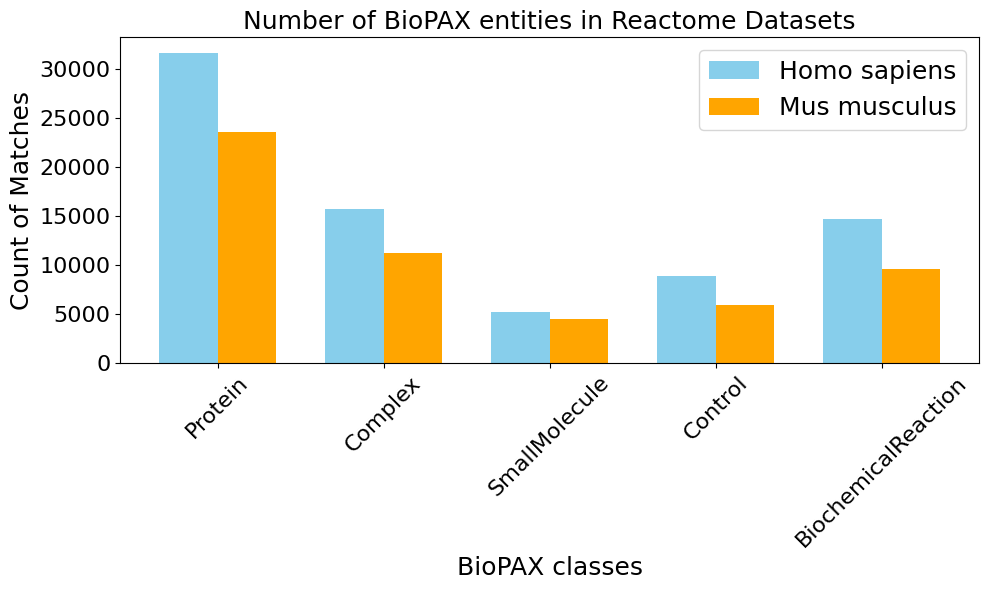

In [10]:
 
exfile="data/output/metrics_simple.pdf"  
xlabel="BioPAX classes"
ylabel="Count of Matches"
title='Number of BioPAX entities in Reactome Datasets'
plt=define_figure(query_counts_ds1,query_counts_ds2,
                  dataset1_label,dataset2_label,xlabel,ylabel,title)
# Save the plot as a PDF file
plt.savefig(exfile)
 

In [11]:
dataset_list=[dataset1,dataset2]

In [12]:
parentClasses=["PhysicalEntity","EntityReference","Interaction"]

sma={}
for cl, children in gu.classes_children().items():
   if cl in parentClasses:
      sma[cl.lower()]=1
 
      for child in children:
         sma[child.lower()]=1
   
selectedClasses=list(sma.keys())

In [13]:
def count_uniq(matches,pmetalabels): 
  global selectedClasses
  uniq={}
  for entity_row in matches:
    for entity in entity_row:
      if entity.cls.lower() in selectedClasses:
        if entity.meta_label is not None and entity.meta_label in pmetalabels:
            if entity.pk in uniq.keys():
             uniq[entity.pk]=uniq[entity.pk]+1
            else:
             uniq[entity.pk]=1
  return len(list(uniq.keys()))   

In [14]:
def prp(data,pe,p,label,pmetalabels):
  res = pe.executePattern(p)

  #data={label:{"matches":count_uniq(res,pmetalabels)}}
  data[label]=count_uniq(res,pmetalabels) 
  print(data)
  querylist=pe.queries(p)


#  for q in querylist:
#      print("#---generated sparql query---\n\n")
#      print(q)


  return data

In [15]:
ds_data={}
for dataset in dataset_list:
  data={}  
  pe = PatternExecutor(db,dataset) # create a Pattern executor for a dataset
 
  data= prp(data,pe,r.controlsStateChange(),"controls-state-change-of",["C1"])
 
  #data= prp(data,pe,r.stateChange(),"state-change",["C1","c"])
   
  data=prp(data,pe,r.controlsPhosphorylation(),"controls-phosphorylation",["C1"])
 
  data=prp(data,pe,r.reactsWith(),"reacts-with",["SMR1"])
 
  data=prp(data,pe,r.usedToProduce(),"used-to-produce",["BR"])
 
  data=prp(data,pe,r.controlsExpressionWithTemplateReac(),"controls-expression-of",["Control"])
 
  data=prp(data,pe,r.inComplexWith(),"in-complex-with",["COMPLEX"])
 
  data=prp(data,pe,r.controlsMetabolicCatalysis(),"control-metabolic-catalysis",["Control"])
  ds_data[dataset]=data

{'controls-state-change-of': 1616}
{'controls-state-change-of': 1616, 'controls-phosphorylation': 707}
{'controls-state-change-of': 1616, 'controls-phosphorylation': 707, 'reacts-with': 104}
{'controls-state-change-of': 1616, 'controls-phosphorylation': 707, 'reacts-with': 104, 'used-to-produce': 4281}
{'controls-state-change-of': 1616, 'controls-phosphorylation': 707, 'reacts-with': 104, 'used-to-produce': 4281, 'controls-expression-of': 5}
{'controls-state-change-of': 1616, 'controls-phosphorylation': 707, 'reacts-with': 104, 'used-to-produce': 4281, 'controls-expression-of': 5, 'in-complex-with': 3026}
{'controls-state-change-of': 1616, 'controls-phosphorylation': 707, 'reacts-with': 104, 'used-to-produce': 4281, 'controls-expression-of': 5, 'in-complex-with': 3026, 'control-metabolic-catalysis': 4462}
{'controls-state-change-of': 1316}
{'controls-state-change-of': 1316, 'controls-phosphorylation': 540}
{'controls-state-change-of': 1316, 'controls-phosphorylation': 540, 'reacts-with

In [16]:
print(ds_data)


{'reactome_homo': {'controls-state-change-of': 1616, 'controls-phosphorylation': 707, 'reacts-with': 104, 'used-to-produce': 4281, 'controls-expression-of': 5, 'in-complex-with': 3026, 'control-metabolic-catalysis': 4462}, 'reactome_mus': {'controls-state-change-of': 1316, 'controls-phosphorylation': 540, 'reacts-with': 96, 'used-to-produce': 3341, 'controls-expression-of': 32, 'in-complex-with': 2542, 'control-metabolic-catalysis': 3424}}


In [17]:
subset={}
selectedIndex=[0,1,3,5,6,7,8,9]
for ds, mapd in ds_data.items():
  subset[ds]={}  
  i=-1  
  for n,ct in mapd.items():
      i=i+1
      if i in selectedIndex:
           subset[ds][n]=ct
          

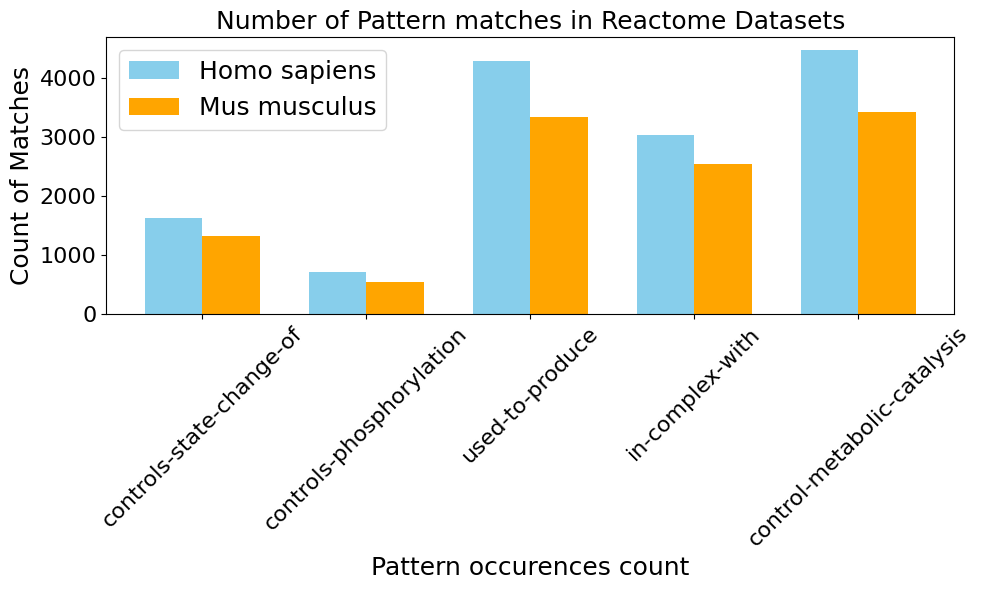

In [18]:
exfile="data/output/metrics_adv.pdf"  
xlabel="Pattern occurences count"
ylabel="Count of Matches"
title='Number of Pattern matches in Reactome Datasets'
plt=define_figure(subset[dataset1],subset[dataset2],
                  dataset1_label,dataset2_label,xlabel,ylabel,title)
# Save the plot as a PDF file
plt.savefig(exfile)
